# Khushi Subgroup 4 - Bankruptcy Prediction Modeling.

## 1. Importing Libraries

In [53]:
print("Importing libraries")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import joblib
import warnings
warnings.filterwarnings('ignore')
print("Libraries imported successfully.\n")

Importing libraries
Libraries imported successfully.



## 2. Loading the Cluster 4 Data

In [54]:
df = pd.read_csv('df_cluster_4.csv')
print(f"Cluster 4 data shape: {df.shape}\n")
df.head(10)

Cluster 4 data shape: (1186, 31)



,ROA(C) before interest and depreciation before interest,Long-term Liability to Current Assets,Current Ratio,Inventory/Current Liability,Total expense/Assets,Operating Expense Rate,Long-term fund suitability ratio (A),Current Asset Turnover Rate,Tax rate (A),Revenue Per Share (Yuan ¥),...,Operating Gross Margin,Cash flow rate,Average Collection Days,Degree of Financial Leverage (DFL),Accounts Receivable Turnover,Net Value Growth Rate,Realized Sales Gross Profit Growth Rate,Cluster,Bankrupt?,Index
0,0.271154,-0.270475,1.878165,-0.091866,0.933722,-0.710131,2.630791,-0.470798,-1.045346,0.118666,...,0.672501,0.945211,-0.097120,-0.119558,-0.153165,-0.003172,-0.071502,4,0,9
1,-0.074437,-0.261282,1.354726,0.185686,0.377035,-0.710025,0.156614,-0.470301,-1.045346,-1.336763,...,2.496470,-0.544932,-0.308210,0.064418,-0.114092,1.519756,-0.040943,4,0,14
2,-0.351847,-0.270475,0.975623,-0.123686,0.380794,-0.710112,-0.241325,-0.470802,-0.093674,-1.219224,...,0.617445,0.094899,0.251546,-0.119558,-0.191145,-0.151131,-0.071768,4,0,17
3,-0.027826,-0.270475,0.381026,-0.089767,0.812197,-0.710138,-0.070407,-0.470891,2.009904,-0.722190,...,0.866052,0.483440,-0.271413,-0.115045,-0.122260,-0.079203,-0.080136,4,0,35
4,0.405393,-0.270475,-0.302006,-0.116450,0.562597,-0.710162,-0.640080,-0.470868,-0.945435,0.165016,...,0.330922,0.027208,0.306025,-0.101199,-0.195406,-0.075601,-0.064658,4,0,39
5,-0.502686,-0.270475,0.667727,-0.065443,0.243768,-0.710160,-0.370061,-0.470834,-0.289752,-0.254211,...,-0.143270,-0.324854,-0.155056,0.062193,-0.144067,-0.146107,-0.050342,4,0,43
6,-1.094667,-0.270475,3.050714,-0.055006,0.873883,-0.710021,1.323025,-0.470473,-1.045346,-1.398206,...,0.788694,-1.718717,0.330100,-0.119558,-0.197233,-0.183896,1.180723,4,0,51
7,-1.093115,-0.270475,2.260008,0.002283,-0.233344,-0.710090,-0.578737,-0.470585,-1.045346,-1.352503,...,-0.665511,-0.755186,0.183047,-0.123469,-0.185365,0.104976,0.698789,4,0,52
8,0.427413,-0.270475,0.489038,-0.191490,0.607147,-0.710143,-0.299825,-0.470835,-1.045346,-0.270749,...,0.853899,0.105645,-0.265840,-0.111151,-0.123470,-0.077682,-0.052616,4,0,61
9,-1.284987,-0.270475,3.190245,3.611300,-1.412924,1.409128,-0.082209,-0.470849,-1.045346,-0.862965,...,-1.350734,2.912489,-0.934229,-0.119861,0.531831,-0.220445,-0.291549,4,0,62


## 3. Preparing Features and Target

In [55]:
X = df.drop(columns=['Cluster', 'Bankrupt?', 'Index'])
y = df['Bankrupt?']
print(f"Number of features used: {X.shape[1]}\n")


Number of features used: 28



## 4. Selecting Top 5 Features

In [56]:
print("Selecting Top 5 Features")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X, y)
top_5_features = pd.Series(rf_selector.feature_importances_, index=X.columns).sort_values(ascending=False).head(5).index.tolist()
X_keep = X[top_5_features]
print("Top 5 Features Selected:")
print(top_5_features)

Selecting Top 5 Features
Top 5 Features Selected:
[' Net Value Growth Rate', ' Total expense/Assets', ' ROA(C) before interest and depreciation before interest', ' Degree of Financial Leverage (DFL)', ' Total debt/Total net worth']


## 5. Defining Base Models and Meta Model

### Why These Base Models and Stacking Model Were Chosen

- **Random Forest Classifier:**
  A powerful ensemble method based on decision trees. It reduces overfitting, handles high-dimensional data well,
  and provides feature importance, making it ideal for bankruptcy prediction tasks.

- **K-Nearest Neighbors (KNN):**
  A simple, instance-based learning algorithm that makes predictions based on proximity to neighboring data points.
  It is useful because it makes no assumptions about the underlying data distribution.

- **Gradient Boosting Classifier:**
  An ensemble technique that builds weak learners sequentially to correct errors from previous learners.
  It performs exceptionally well for structured tabular datasets and handles class imbalance with careful tuning.

**Meta-Model:**

- **Logistic Regression:**
  A simple yet effective linear classifier that combines the outputs from base models.
  Logistic regression avoids overfitting and provides strong generalization when using high-quality base model predictions.

Building stacking classifier
Training accuracy (meta-model): 0.929

Number of features used: 5


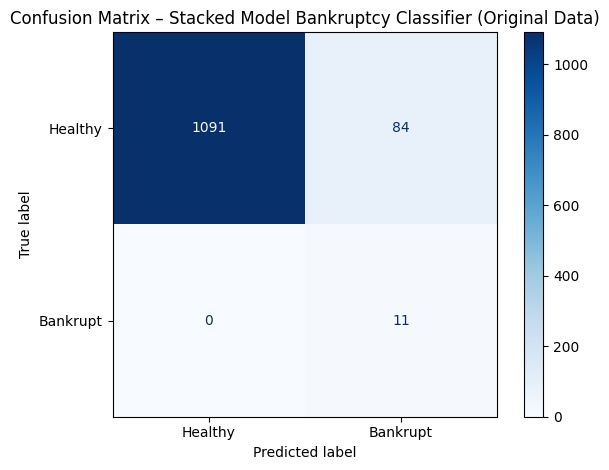

In [57]:
# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42, class_weight = 'balanced')),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('gb', GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, random_state=42))
]

# Define meta model
meta_model = LogisticRegression(max_iter=1000, random_state=42 , class_weight = 'balanced')

print("Building stacking classifier")
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=10,
    passthrough=True
)

stacking_clf.fit(X_keep, y)

train_acc_meta = stacking_clf.score(X_keep, y)
print(f"Training accuracy (meta-model): {train_acc_meta:.3f}")

n_features_used = X_keep.shape[1]
print(f"\nNumber of features used: {n_features_used}")

y_pred_full = stacking_clf.predict(X_keep)

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y, y_pred_full,
    display_labels=["Healthy", "Bankrupt"],
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix – Stacked Model Bankruptcy Classifier (Original Data)")
plt.tight_layout()
plt.show()


In [58]:
# Print Accuracy score [TT(TF)] for stacked model
acc = accuracy_score(y, y_pred_full)

# Compute TT (true bankrupt predicted bankrupt) and TF (false bankrupt predicted healthy)
TT = ((y == 1) & (y_pred_full == 1)).sum()  # True Bankrupt predicted as Bankrupt
TF = ((y == 1) & (y_pred_full == 0)).sum()  # True Bankrupt predicted as Healthy

# Print final output in your desired format
print(f"\nAccuracy (Meta Model) [TT(TF)]: {acc:.3f} [{TT}({TF})]")


Accuracy (Meta Model) [TT(TF)]: 0.929 [11(0)]


Training accuracy (Random Forest): 1.000 [11(0)]


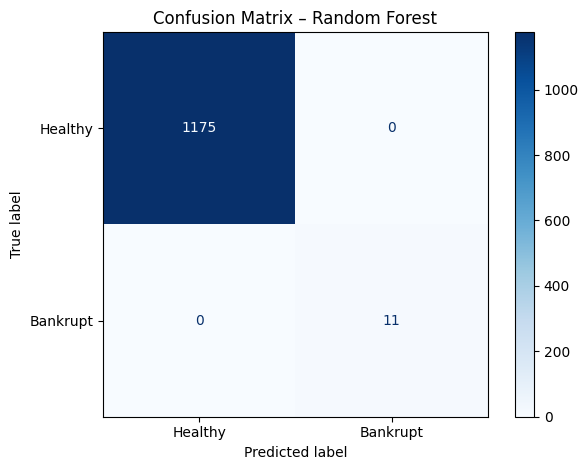

Training accuracy (kNN): 0.991 [0(0)]


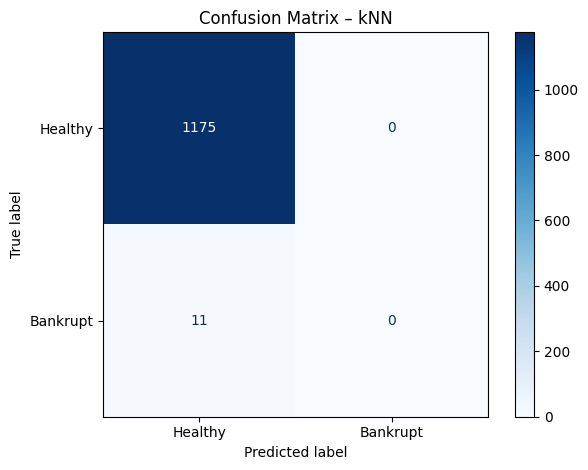

Training accuracy (Gradient Boost): 1.000 [11(0)]


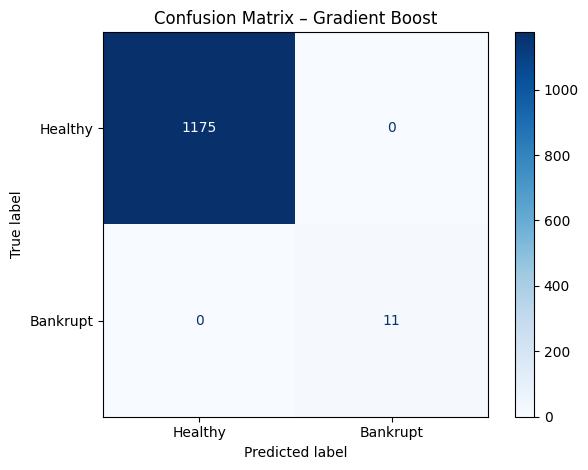


Average training accuracy of base models: 0.997
Average TT(TF): 7.3(0.0)


In [59]:
# Base Models' Avg Accuracy score, [TT(TF)], and Confusion Matrices

base_model_accuracies = []
base_model_TT = []
base_model_TF = []

def evaluate_model(model, X, y, model_name):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    base_model_accuracies.append(acc)
    base_model_TT.append(tp)
    base_model_TF.append(fp)
    
    print(f"Training accuracy ({model_name}): {acc:.3f} [{tp}({fp})]")
    
    # Plot confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Bankrupt"]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix – {model_name}")
    plt.tight_layout()
    plt.show()

# --- evaluate each base model ---
evaluate_model(stacking_clf.named_estimators_['rf'], X_keep, y, 'Random Forest')
evaluate_model(stacking_clf.named_estimators_['knn'], X_keep, y, 'kNN')
evaluate_model(stacking_clf.named_estimators_['gb'], X_keep, y, 'Gradient Boost')

# --- compute and print average accuracy ---
avg_base_acc = np.mean(base_model_accuracies)
print(f"\nAverage training accuracy of base models: {avg_base_acc:.3f}")

avg_TT = np.mean(base_model_TT)
avg_TF = np.mean(base_model_TF)
print(f"Average TT(TF): {avg_TT:.1f}({avg_TF:.1f})")

## Saving Final Stacking Model

In [60]:
print("\nSaving final stacking model...")
joblib.dump(stacking_clf, 'cluster4_stacking_model.joblib')
print("Model saved successfully as 'cluster4_stacking_model.joblib'.")


Saving final stacking model...
Model saved successfully as 'cluster4_stacking_model.joblib'.


In [61]:
new_train_df = df[[' Net Value Growth Rate', ' Total expense/Assets', ' ROA(C) before interest and depreciation before interest', ' Degree of Financial Leverage (DFL)', ' Total debt/Total net worth']]
joblib.dump(new_train_df, "cluster4_train_data.joblib")
print("Saved selected features to cluster4_train_data.joblib")

Saved selected features to cluster4_train_data.joblib
